## Analysis of the topics created by the Top2Vec model

- Primitives are loaded, as well as the topic weights of the reduced top2vec model (100 topics) --> see part II in `top2vec_training.ipynb`.
- They are merged into one df.
- Topics are plotted over time in bins per year, using `agg.('mean')`.
- 



In [34]:
import ndjson
import nolds
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

import sys
sys.path.append('../chronicles/')

from entropies.afa import adaptive_filter


### Scaling

- We use the original representations of the cosine similarity, ranging from -1 to +1.
- We apply the `TimeSeriesScalerMeanVariance` in `tslearn.preprocessing`.

### Smoothening

- Smoothening with a Gaussian kernel
- Calculating DFA
- Smoothening with AFA

In [40]:
year_mean_scaled = pd.read_csv('../../corpus/primitives_220503/year_mean_scaled.csv', index_col=0)
year_mean_scaled.head()

,year,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,1450,-0.347744,-2.885364,-1.935623,-1.078644,-1.045707,-3.375432,-2.245966,1.270294,-1.971427,...,2.572450,1.451025,3.055796,-0.871671,1.384250,-0.503171,-2.558269,-1.061521,-0.584966,-1.445818
1,1451,-0.109758,0.105516,-1.231864,1.175338,-1.097890,-1.698865,-0.946234,-1.919857,0.368475,...,-1.983998,-1.856676,1.349444,0.193142,-3.380008,2.071746,-2.030386,-2.335141,-0.926295,1.272949
2,1452,-2.988596,-1.496043,-4.099228,-3.231396,-3.583630,-2.838880,-0.726331,-2.315084,2.523190,...,0.412499,-3.834094,-3.448200,-3.272283,-1.629773,-4.570878,-4.733714,-1.601552,-4.413219,-1.047289
3,1453,0.447855,1.206903,-0.286604,-1.399576,-1.303929,1.172551,-0.453265,2.029056,-1.869970,...,2.282380,-0.711540,0.541349,0.549170,-1.758583,-1.672723,-0.568204,-1.292769,0.037986,2.453037
4,1454,-1.027839,-0.181444,1.058765,-0.517218,0.862278,-0.664462,-1.340962,-0.465456,1.934687,...,-1.495838,-0.746831,-0.761404,-0.388862,-0.580487,0.312872,-1.977898,0.288114,1.141342,0.835148


### Smoothening with a Gaussian kernel

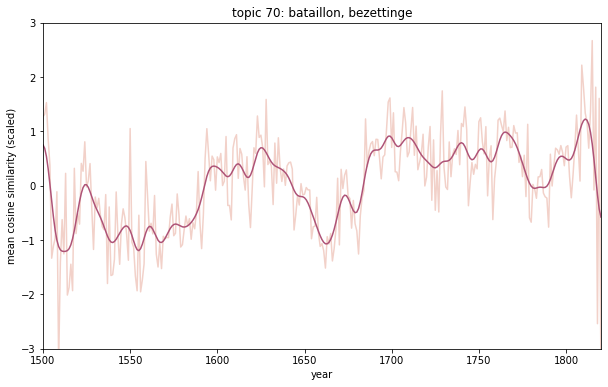

In [41]:
#fig, (axes) = plt.subplots(3, 1, figsize=(4, 12), sharey=False)

topic = [*range(0,100)]
topic = [str(x) for x in topic]

smooth = gaussian_filter1d(year_mean_scaled[topic[70]].to_numpy(), 3)
plt.figure(figsize=(10, 6))
sns.lineplot(year_mean_scaled['year'], year_mean_scaled[topic[70]], color='#F2D1C9')
sns.lineplot(year_mean_scaled['year'], smooth, color='#AE5377')
plt.title('topic 70: bataillon, bezettinge')
plt.xlabel('year')
plt.ylabel('mean cosine similarity (scaled)')
plt.xlim([1500, 1820])
plt.ylim([-3, +3])
plt.show()

(-3.0, 3.0)

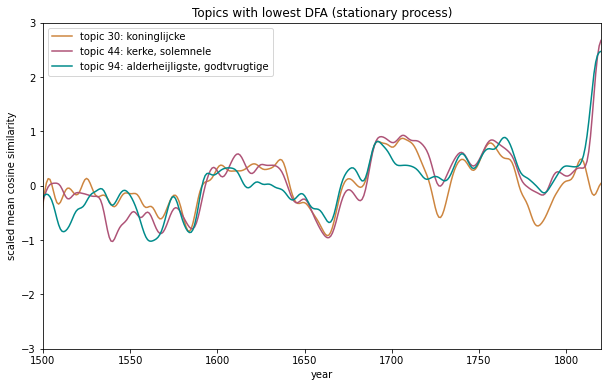

In [42]:
plt.figure(figsize=(10, 6))
smooth0 = gaussian_filter1d(year_mean_scaled[topic[30]].to_numpy(), 3)
sns.lineplot(year_mean_scaled['year'], smooth0, color='peru')
smooth1 = gaussian_filter1d(year_mean_scaled[topic[44]].to_numpy(), 3)
sns.lineplot(year_mean_scaled['year'], smooth1, color='#AE5377')
smooth2 = gaussian_filter1d(year_mean_scaled[topic[94]].to_numpy(), 3)
sns.lineplot(year_mean_scaled['year'], smooth2, color='#008B8B')
plt.title('Topics with lowest DFA (stationary process)')
plt.legend(['topic 30: koninglijcke', 'topic 44: kerke, solemnele', 'topic 94: alderheijligste, godtvrugtige'])
plt.xlabel('year')
plt.ylabel('scaled mean cosine similarity')
plt.xlim([1500, 1820])
plt.ylim([-3, +3])

(-3.0, 3.0)

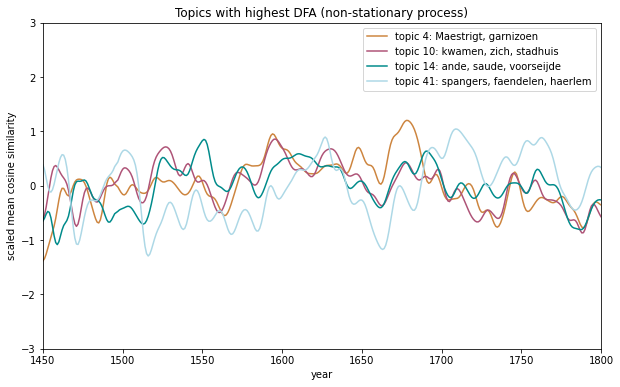

In [43]:
plt.figure(figsize=(10, 6))
smooth0 = gaussian_filter1d(year_mean_scaled[topic[4]].to_numpy(), 3)
sns.lineplot(year_mean_scaled['year'], smooth0, color='peru')
smooth1 = gaussian_filter1d(year_mean_scaled[topic[10]].to_numpy(), 3)
sns.lineplot(year_mean_scaled['year'], smooth1, color='#AE5377')
smooth2 = gaussian_filter1d(year_mean_scaled[topic[14]].to_numpy(), 3)
sns.lineplot(year_mean_scaled['year'], smooth2, color='#008B8B')
smooth3 = gaussian_filter1d(year_mean_scaled[topic[41]].to_numpy(), 3)
sns.lineplot(year_mean_scaled['year'], smooth3, color='#ADD8E6')
plt.title('Topics with highest DFA (non-stationary process)')
plt.legend(['topic 4: Maestrigt, garnizoen', 'topic 10: kwamen, zich, stadhuis', 'topic 14: ande, saude, voorseijde', 'topic 41: spangers, faendelen, haerlem'])
plt.xlabel('year')
plt.ylabel('scaled mean cosine similarity')
plt.xlim([1450, 1800])
plt.ylim([-3, +3])

## DFA (Detrended Fluctuation Analysis)

On what time range should DFA be calculated?

In [44]:
year_mean = pd.read_csv('../../corpus/primitives_220503/year_mean.csv', index_col=0)
year_mean.head()

,year,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,1450,0.144094,-0.001072,0.082953,0.113788,0.113303,0.041212,0.072366,0.208974,0.095439,...,0.271695,0.232806,0.279087,0.124345,0.226482,0.145655,0.058694,0.131272,0.155223,0.102537
1,1451,0.161351,0.162178,0.109440,0.198016,0.111266,0.098100,0.121208,0.075914,0.169595,...,0.078617,0.078885,0.212889,0.173683,0.011023,0.250858,0.080643,0.087130,0.140075,0.242289
2,1452,-0.047410,0.074761,0.001524,0.033343,0.014243,0.059418,0.129471,0.059429,0.237882,...,0.180168,-0.013133,0.026765,0.013114,0.090175,-0.020540,-0.031760,0.112555,-0.014673,0.123022
3,1453,0.201787,0.222295,0.145015,0.101795,0.103224,0.195532,0.139733,0.240622,0.098654,...,0.259403,0.132173,0.181539,0.190179,0.084350,0.097870,0.141439,0.123257,0.182869,0.302949
4,1454,0.094776,0.146515,0.195649,0.134768,0.187776,0.133199,0.106374,0.136576,0.219231,...,0.099303,0.130531,0.130999,0.146716,0.137628,0.178996,0.082825,0.178049,0.231835,0.219785


In [45]:
topic = [*range(0,100)]
topic = [str(x) for x in topic]

nolds.dfa(year_mean[topic[54]])

0.828437521917354

In [46]:
dfa_list = []

for i in range(0,100):
    dfa_list.append(nolds.dfa(year_mean[topic[i]]))

In [47]:
max_value = max(dfa_list)
min_value = min(dfa_list)

max_index = dfa_list.index(max_value)
min_index = dfa_list.index(min_value)

In [48]:
print(max_value)
print(min_value)
print(max_index)
print(min_index)

1.09191283408474
0.6378608465039375
0
7


In [51]:
[i for i,v in enumerate(dfa_list) if v < 0.65]

[7, 11, 14]

In [50]:
[i for i,v in enumerate(dfa_list) if v > 0.89]

[0, 1, 70]

## AFA

In [52]:
weak_smooth = adaptive_filter(year_mean_scaled[topic[10]].to_numpy(), span=150)
strong_smooth = adaptive_filter(year_mean_scaled[topic[10]].to_numpy(), span=100)

(-3.0, 3.0)

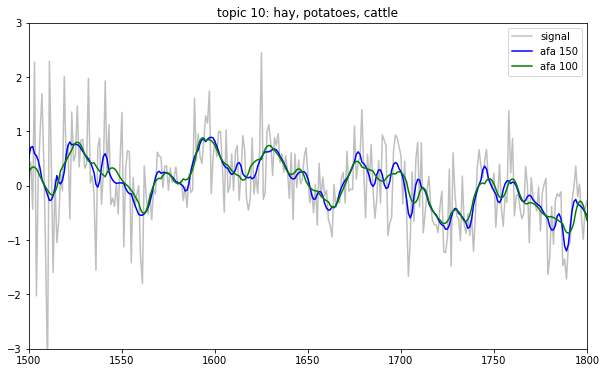

In [53]:
plt.figure(figsize=(10,6))
plt.plot(year_mean_scaled['year'], year_mean_scaled[topic[10]], alpha=0.5, c='grey')
plt.plot(year_mean_scaled['year'], weak_smooth, c='blue')
plt.plot(year_mean_scaled['year'], strong_smooth, c='green')
#plt.plot(year_mean_scaled['year'], smooth1, c='red')
plt.title('topic 10: hay, potatoes, cattle')
plt.legend(['signal', 'afa 150', 'afa 100'])
plt.xlim([1500,1800])
plt.ylim([-3, 3])